# Red para COVID-19

Esta es una red secuencial simple para tratar de predecir el dato de número de contagiados de COVID19 en México que se da a las 19:00 horas por parte del gobierno.

**Para ejecutar la predicción:**

**1)** Ejecutar processing.sh, este script descarga el archivo time_series_covid19_confirmed_global.csv con datos de contagiados por país. Este archivo se actualiza en internet aproximadamente a las 6:30pm con datos del día anterior, hay que revisar que esté actualizado a la fecha del día de la predicción.

chmod +x processing.sh

./processing.sh

**2)** Abrir jupyter notebook (se requiere keras, tensorflow, pandas y numpy instaldos).

jupyter notebook COVID-19.ipynb

**3)** Actualizar dias_a_usar y dia_a_predecir. Como referencia, el 30 de marzo fue el día 33 de infección en México, por lo que dia_a_predecir=33 y dias_a_usar=32.

**4)** Ejecutar todos los cuadros.

**Creado por Juan Felipe Huan Lew Yee, Neftalí Isaí Rodríguez Rojas y Jorge Martín del Campo Ramírez.**

Definimos el dia que queremos la prediccion

In [1]:
dia_a_predecir = 50
dias_a_usar = 49

Definimos la lista de paises que analizaremos. (Más abajo se filtrarán los que no tengan suficientes días)

In [2]:
country_namelist = ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Andorra', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Korea South', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malaysia', 'Maldives', 'Malta', 'Mauritania', 'Mauritius', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'San Marino', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Singapore', 'Slovakia', 'Slovenia', 'Somalia', 'South Africa', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Tanzania', 'Thailand', 'Togo', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uruguay', 'US', 'Uzbekistan', 'Venezuela', 'Vietnam', 'Zambia', 'Zimbabwe', 'Dominica', 'Grenada', 'Mozambique', 'Syria', 'Timor-Leste', 'Belize', 'Laos', 'Libya', 'Guinea-Bissau', 'Mali', 'Saint Kitts and Nevis', 'Burma', 'Botswana', 'Burundi', 'Sierra Leone', 'Malawi']

Filtramos los países que no tengan el número de días necesarios para predecir a México, los países a usar al menos deben de tener dia_a_predecir días de infección.

In [3]:
db = open('database.csv','w')

for value in range(dias_a_usar):
    print(value+1,file=db,end = ',')
print(dia_a_predecir,file=db)

for country in country_namelist:
    
    f = open('database_confirmed.csv')
    infected = []
    dia_inicio = 0
    for line in f:
        if(country == line.split(',')[1]):
            country_data = []
            data = line.replace('\n','').split(',')[4:]
            for number in data:
                if(number != '0'):
                    infected.append(int(number))
                else:
                    dia_inicio += 1                    
    f.close()

    if(len(infected)<=dia_a_predecir):
        #print(country,len(infected))
        continue
    print(country,end=',',file=db,sep=',')
    for value in infected[:dias_a_usar]:
        print(value,file=db,end = ',')
    print(infected[dia_a_predecir-1],file=db)
db.close()          

Importamos librerias

In [5]:
import numpy as np
import keras
import pandas as pd

Leamos la base de datos que acabamos de crear.

In [6]:
data = pd.read_csv("database.csv",sep=',') 

Imprimimos la base de datos

In [6]:
data

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
Afghanistan,1,1,1,1,1,1,1,1,1,1,...,299,349,367,423,444,484,521,555,607,665
Algeria,1,1,1,1,1,1,3,5,12,12,...,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
Australia,4,5,5,6,9,9,12,12,12,13,...,60,63,76,91,107,128,128,200,250,297
Austria,2,2,3,3,9,14,18,21,29,41,...,12051,12297,12639,12942,13244,13555,13806,13945,14041,14226
Bahrain,1,23,33,33,36,41,47,49,49,52,...,688,700,756,811,823,887,925,1040,1136,1361
Belgium,1,1,1,1,1,1,1,1,1,1,...,886,1058,1243,1486,1795,2257,2815,3401,3743,4269
Cambodia,1,1,1,1,1,1,1,1,1,1,...,1,2,2,2,3,3,5,7,7,7
Canada,1,1,2,2,2,4,4,4,4,4,...,49,54,64,77,79,108,117,193,198,252
China,548,643,920,1406,2075,2877,5509,6087,8141,9802,...,80136,80261,80386,80537,80690,80770,80823,80860,80887,80921
Croatia,1,3,3,5,6,7,7,9,10,10,...,1182,1222,1282,1343,1407,1495,1534,1600,1650,1704


Creamos un conjunto X y un conjunto Y y dividimos train y test

In [7]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame()
for i in range(1,dias_a_usar+1):
    X[str(i)] = data[str(i)]
Y = pd.DataFrame()
Y[str(dia_a_predecir)] = data[str(dia_a_predecir)]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(36, 49) (36, 1)
(2, 49) (2, 1)


Creamos la red neuronal

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

model = Sequential()
model.add(Dense(64, input_dim=dias_a_usar+0, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

Compilamos la red

In [9]:
model.compile(loss='MAPE', optimizer='adam')

Entrenamos la red

In [10]:
history = model.fit(X_train, y_train, epochs=1500, validation_data=(X_test,y_test))

Train on 36 samples, validate on 2 samples
Epoch 1/1500
36/36 [==============================] - 1s 36ms/step - loss: 104.6179 - val_loss: 87.3494
Epoch 2/1500
36/36 [==============================] - 0s 1ms/step - loss: 95.2476 - val_loss: 69.9702
Epoch 3/1500
36/36 [==============================] - 0s 1ms/step - loss: 85.8478 - val_loss: 50.0053
Epoch 4/1500
36/36 [==============================] - 0s 1ms/step - loss: 74.7330 - val_loss: 25.8791
Epoch 5/1500
36/36 [==============================] - 0s 575us/step - loss: 63.8340 - val_loss: 36.0799
Epoch 6/1500
36/36 [==============================] - 0s 1ms/step - loss: 50.2528 - val_loss: 46.0342
Epoch 7/1500
36/36 [==============================] - 0s 763us/step - loss: 39.4277 - val_loss: 77.8150
Epoch 8/1500
36/36 [==============================] - 0s 448us/step - loss: 33.8712 - val_loss: 97.8283
Epoch 9/1500
36/36 [==============================] - 0s 399us/step - loss: 34.4208 - val_loss: 104.7762
Epoch 10/1500
36/36 [=======

Epoch 79/1500
36/36 [==============================] - 0s 450us/step - loss: 7.8315 - val_loss: 13.5689
Epoch 80/1500
36/36 [==============================] - 0s 524us/step - loss: 5.9978 - val_loss: 20.4179
Epoch 81/1500
36/36 [==============================] - 0s 591us/step - loss: 8.4126 - val_loss: 15.2778
Epoch 82/1500
36/36 [==============================] - 0s 1ms/step - loss: 6.9575 - val_loss: 7.0902
Epoch 83/1500
36/36 [==============================] - 0s 573us/step - loss: 7.8957 - val_loss: 13.7412
Epoch 84/1500
36/36 [==============================] - 0s 614us/step - loss: 5.8018 - val_loss: 19.9559
Epoch 85/1500
36/36 [==============================] - 0s 946us/step - loss: 7.9785 - val_loss: 14.6726
Epoch 86/1500
36/36 [==============================] - 0s 361us/step - loss: 6.4135 - val_loss: 7.5494
Epoch 87/1500
36/36 [==============================] - 0s 435us/step - loss: 8.0296 - val_loss: 12.7052
Epoch 88/1500
36/36 [==============================] - 0s 438us/step

36/36 [==============================] - ETA: 0s - loss: 4.272 - 0s 563us/step - loss: 4.1183 - val_loss: 19.1785
Epoch 158/1500
36/36 [==============================] - 0s 654us/step - loss: 6.0306 - val_loss: 18.5580
Epoch 159/1500
36/36 [==============================] - 0s 356us/step - loss: 5.5226 - val_loss: 11.4756
Epoch 160/1500
36/36 [==============================] - 0s 544us/step - loss: 5.8030 - val_loss: 8.4270
Epoch 161/1500
36/36 [==============================] - 0s 451us/step - loss: 6.1944 - val_loss: 11.6805
Epoch 162/1500
36/36 [==============================] - 0s 507us/step - loss: 4.3582 - val_loss: 13.6533
Epoch 163/1500
36/36 [==============================] - 0s 462us/step - loss: 5.7148 - val_loss: 9.0912
Epoch 164/1500
36/36 [==============================] - 0s 367us/step - loss: 4.8870 - val_loss: 5.0775
Epoch 165/1500
36/36 [==============================] - 0s 516us/step - loss: 5.7866 - val_loss: 6.6127
Epoch 166/1500
36/36 [============================

36/36 [==============================] - 0s 719us/step - loss: 3.2259 - val_loss: 11.1814
Epoch 235/1500
36/36 [==============================] - 0s 428us/step - loss: 3.4672 - val_loss: 11.2778
Epoch 236/1500
36/36 [==============================] - 0s 364us/step - loss: 4.0202 - val_loss: 8.2540
Epoch 237/1500
36/36 [==============================] - 0s 384us/step - loss: 3.2212 - val_loss: 11.2948
Epoch 238/1500
36/36 [==============================] - 0s 347us/step - loss: 3.1033 - val_loss: 14.0995
Epoch 239/1500
36/36 [==============================] - 0s 377us/step - loss: 3.6886 - val_loss: 13.9210
Epoch 240/1500
36/36 [==============================] - 0s 364us/step - loss: 3.4931 - val_loss: 11.7598
Epoch 241/1500
36/36 [==============================] - 0s 453us/step - loss: 2.9791 - val_loss: 10.5039
Epoch 242/1500
36/36 [==============================] - 0s 323us/step - loss: 3.3584 - val_loss: 10.2724
Epoch 243/1500
36/36 [==============================] - 0s 1ms/step - l

36/36 [==============================] - 0s 438us/step - loss: 3.2021 - val_loss: 13.8170
Epoch 313/1500
36/36 [==============================] - 0s 370us/step - loss: 3.1009 - val_loss: 16.4459
Epoch 314/1500
36/36 [==============================] - 0s 360us/step - loss: 3.4795 - val_loss: 14.1098
Epoch 315/1500
36/36 [==============================] - 0s 380us/step - loss: 3.8295 - val_loss: 12.4925
Epoch 316/1500
36/36 [==============================] - 0s 501us/step - loss: 4.6238 - val_loss: 11.6172
Epoch 317/1500
36/36 [==============================] - 0s 578us/step - loss: 3.5380 - val_loss: 13.8017
Epoch 318/1500
36/36 [==============================] - 0s 902us/step - loss: 3.9611 - val_loss: 7.6895
Epoch 319/1500
36/36 [==============================] - 0s 521us/step - loss: 3.3647 - val_loss: 2.6227
Epoch 320/1500
36/36 [==============================] - 0s 721us/step - loss: 6.3236 - val_loss: 6.6772
Epoch 321/1500
36/36 [==============================] - 0s 639us/step - l

36/36 [==============================] - 0s 423us/step - loss: 2.9269 - val_loss: 10.6269
Epoch 391/1500
36/36 [==============================] - 0s 496us/step - loss: 2.5743 - val_loss: 16.2630
Epoch 392/1500
36/36 [==============================] - 0s 411us/step - loss: 3.4747 - val_loss: 11.2353
Epoch 393/1500
36/36 [==============================] - 0s 504us/step - loss: 3.0778 - val_loss: 12.0085
Epoch 394/1500
36/36 [==============================] - 0s 412us/step - loss: 2.4991 - val_loss: 19.8625
Epoch 395/1500
36/36 [==============================] - 0s 423us/step - loss: 5.5967 - val_loss: 14.3331
Epoch 396/1500
36/36 [==============================] - 0s 691us/step - loss: 3.1078 - val_loss: 5.2250
Epoch 397/1500
36/36 [==============================] - 0s 1ms/step - loss: 6.0497 - val_loss: 5.0827
Epoch 398/1500
36/36 [==============================] - 0s 721us/step - loss: 3.8281 - val_loss: 9.9970
Epoch 399/1500
36/36 [==============================] - 0s 355us/step - los

36/36 [==============================] - 0s 370us/step - loss: 2.9896 - val_loss: 8.8292
Epoch 469/1500
36/36 [==============================] - 0s 384us/step - loss: 2.7831 - val_loss: 12.8447
Epoch 470/1500
36/36 [==============================] - 0s 446us/step - loss: 3.3439 - val_loss: 7.3733
Epoch 471/1500
36/36 [==============================] - 0s 426us/step - loss: 3.1342 - val_loss: 6.9013
Epoch 472/1500
36/36 [==============================] - 0s 414us/step - loss: 3.3353 - val_loss: 14.1609
Epoch 473/1500
36/36 [==============================] - 0s 536us/step - loss: 3.8004 - val_loss: 13.9914
Epoch 474/1500
36/36 [==============================] - 0s 470us/step - loss: 4.1883 - val_loss: 7.9272
Epoch 475/1500
36/36 [==============================] - 0s 456us/step - loss: 3.2246 - val_loss: 5.8526
Epoch 476/1500
36/36 [==============================] - 0s 528us/step - loss: 3.5751 - val_loss: 10.7078
Epoch 477/1500
36/36 [==============================] - 0s 431us/step - los

36/36 [==============================] - ETA: 0s - loss: 2.320 - 0s 444us/step - loss: 2.4053 - val_loss: 11.1931
Epoch 546/1500
36/36 [==============================] - 0s 527us/step - loss: 2.7408 - val_loss: 6.2815
Epoch 547/1500
36/36 [==============================] - 0s 602us/step - loss: 3.5832 - val_loss: 9.4893
Epoch 548/1500
36/36 [==============================] - 0s 363us/step - loss: 2.5905 - val_loss: 14.3828
Epoch 549/1500
36/36 [==============================] - 0s 414us/step - loss: 2.7705 - val_loss: 9.2267
Epoch 550/1500
36/36 [==============================] - 0s 383us/step - loss: 2.8907 - val_loss: 11.9538
Epoch 551/1500
36/36 [==============================] - 0s 413us/step - loss: 1.9630 - val_loss: 14.9151
Epoch 552/1500
36/36 [==============================] - 0s 498us/step - loss: 3.3833 - val_loss: 6.1412
Epoch 553/1500
36/36 [==============================] - 0s 445us/step - loss: 4.2097 - val_loss: 5.1802
Epoch 554/1500
36/36 [=============================

36/36 [==============================] - 0s 570us/step - loss: 2.3271 - val_loss: 17.4582
Epoch 624/1500
36/36 [==============================] - 0s 377us/step - loss: 2.7437 - val_loss: 15.9452
Epoch 625/1500
36/36 [==============================] - 0s 479us/step - loss: 2.8418 - val_loss: 15.8665
Epoch 626/1500
36/36 [==============================] - 0s 477us/step - loss: 2.9442 - val_loss: 13.9352
Epoch 627/1500
36/36 [==============================] - 0s 1ms/step - loss: 2.2444 - val_loss: 8.9503
Epoch 628/1500
36/36 [==============================] - 0s 1ms/step - loss: 1.7445 - val_loss: 11.0165
Epoch 629/1500
36/36 [==============================] - 0s 554us/step - loss: 3.7727 - val_loss: 10.3654
Epoch 630/1500
36/36 [==============================] - 0s 503us/step - loss: 4.8809 - val_loss: 7.9025
Epoch 631/1500
36/36 [==============================] - 0s 727us/step - loss: 2.9302 - val_loss: 9.1463
Epoch 632/1500
36/36 [==============================] - 0s 975us/step - loss:

36/36 [==============================] - 0s 504us/step - loss: 2.4248 - val_loss: 15.7094
Epoch 702/1500
36/36 [==============================] - 0s 531us/step - loss: 2.9835 - val_loss: 17.9826
Epoch 703/1500
36/36 [==============================] - 0s 576us/step - loss: 2.9524 - val_loss: 13.3930
Epoch 704/1500
36/36 [==============================] - 0s 457us/step - loss: 1.4441 - val_loss: 7.7470
Epoch 705/1500
36/36 [==============================] - 0s 339us/step - loss: 2.5783 - val_loss: 7.4776
Epoch 706/1500
36/36 [==============================] - 0s 694us/step - loss: 2.4903 - val_loss: 9.7161
Epoch 707/1500
36/36 [==============================] - 0s 324us/step - loss: 1.6967 - val_loss: 14.8131
Epoch 708/1500
36/36 [==============================] - 0s 508us/step - loss: 3.0463 - val_loss: 15.3782
Epoch 709/1500
36/36 [==============================] - 0s 543us/step - loss: 3.1472 - val_loss: 8.6579
Epoch 710/1500
36/36 [==============================] - 0s 558us/step - lo

36/36 [==============================] - 0s 424us/step - loss: 3.0143 - val_loss: 12.6401
Epoch 780/1500
36/36 [==============================] - 0s 479us/step - loss: 5.1178 - val_loss: 12.2017
Epoch 781/1500
36/36 [==============================] - 0s 539us/step - loss: 5.0079 - val_loss: 18.2286
Epoch 782/1500
36/36 [==============================] - 0s 507us/step - loss: 4.6553 - val_loss: 20.3557
Epoch 783/1500
36/36 [==============================] - 0s 520us/step - loss: 5.3510 - val_loss: 9.7624
Epoch 784/1500
36/36 [==============================] - 0s 548us/step - loss: 4.3422 - val_loss: 7.0944
Epoch 785/1500
36/36 [==============================] - 0s 529us/step - loss: 7.6228 - val_loss: 6.5366
Epoch 786/1500
36/36 [==============================] - 0s 622us/step - loss: 3.7844 - val_loss: 14.2271
Epoch 787/1500
36/36 [==============================] - 0s 488us/step - loss: 3.7768 - val_loss: 13.8228
Epoch 788/1500
36/36 [==============================] - 0s 739us/step - l

36/36 [==============================] - 0s 650us/step - loss: 1.9791 - val_loss: 17.4595
Epoch 858/1500
36/36 [==============================] - 0s 1ms/step - loss: 4.4117 - val_loss: 11.6575
Epoch 859/1500
36/36 [==============================] - 0s 1ms/step - loss: 1.8660 - val_loss: 7.0222
Epoch 860/1500
36/36 [==============================] - 0s 635us/step - loss: 3.4986 - val_loss: 10.7851
Epoch 861/1500
36/36 [==============================] - 0s 429us/step - loss: 2.6414 - val_loss: 12.6056
Epoch 862/1500
36/36 [==============================] - 0s 731us/step - loss: 3.1514 - val_loss: 8.2523
Epoch 863/1500
36/36 [==============================] - 0s 350us/step - loss: 3.5011 - val_loss: 9.2204
Epoch 864/1500
36/36 [==============================] - 0s 380us/step - loss: 3.7064 - val_loss: 16.1118
Epoch 865/1500
36/36 [==============================] - 0s 377us/step - loss: 3.5954 - val_loss: 17.9279
Epoch 866/1500
36/36 [==============================] - 0s 452us/step - loss:

36/36 [==============================] - 0s 462us/step - loss: 5.9216 - val_loss: 17.0068
Epoch 936/1500
36/36 [==============================] - 0s 2ms/step - loss: 2.8152 - val_loss: 9.6614
Epoch 937/1500
36/36 [==============================] - 0s 389us/step - loss: 5.1614 - val_loss: 10.1508
Epoch 938/1500
36/36 [==============================] - 0s 625us/step - loss: 2.2126 - val_loss: 14.1221
Epoch 939/1500
36/36 [==============================] - 0s 589us/step - loss: 3.4852 - val_loss: 10.7164
Epoch 940/1500
36/36 [==============================] - 0s 335us/step - loss: 2.6447 - val_loss: 13.0968
Epoch 941/1500
36/36 [==============================] - 0s 421us/step - loss: 1.6616 - val_loss: 21.9713
Epoch 942/1500
36/36 [==============================] - 0s 434us/step - loss: 3.5572 - val_loss: 24.0829
Epoch 943/1500
36/36 [==============================] - 0s 449us/step - loss: 3.6833 - val_loss: 19.6654
Epoch 944/1500
36/36 [==============================] - 0s 445us/step - l

36/36 [==============================] - 0s 511us/step - loss: 1.6905 - val_loss: 10.9307
Epoch 1014/1500
36/36 [==============================] - 0s 329us/step - loss: 2.1635 - val_loss: 9.8462
Epoch 1015/1500
36/36 [==============================] - 0s 423us/step - loss: 1.8433 - val_loss: 11.8293
Epoch 1016/1500
36/36 [==============================] - 0s 387us/step - loss: 1.6608 - val_loss: 16.5359
Epoch 1017/1500
36/36 [==============================] - 0s 426us/step - loss: 1.8942 - val_loss: 13.9938
Epoch 1018/1500
36/36 [==============================] - 0s 433us/step - loss: 2.8658 - val_loss: 13.2993
Epoch 1019/1500
36/36 [==============================] - 0s 410us/step - loss: 3.0508 - val_loss: 18.3875
Epoch 1020/1500
36/36 [==============================] - 0s 501us/step - loss: 2.9421 - val_loss: 16.5259
Epoch 1021/1500
36/36 [==============================] - 0s 420us/step - loss: 2.2886 - val_loss: 11.6414
Epoch 1022/1500
36/36 [==============================] - 0s 364

Epoch 1090/1500
36/36 [==============================] - 0s 398us/step - loss: 2.7429 - val_loss: 10.9167
Epoch 1091/1500
36/36 [==============================] - 0s 468us/step - loss: 1.5502 - val_loss: 8.9923
Epoch 1092/1500
36/36 [==============================] - 0s 377us/step - loss: 2.8876 - val_loss: 13.2867
Epoch 1093/1500
36/36 [==============================] - 0s 453us/step - loss: 1.8155 - val_loss: 20.2862
Epoch 1094/1500
36/36 [==============================] - 0s 318us/step - loss: 5.1190 - val_loss: 16.8489
Epoch 1095/1500
36/36 [==============================] - 0s 330us/step - loss: 3.1391 - val_loss: 7.4730
Epoch 1096/1500
36/36 [==============================] - 0s 334us/step - loss: 3.3112 - val_loss: 9.1180
Epoch 1097/1500
36/36 [==============================] - 0s 699us/step - loss: 1.4817 - val_loss: 13.1950
Epoch 1098/1500
36/36 [==============================] - 0s 788us/step - loss: 3.3424 - val_loss: 13.9764
Epoch 1099/1500
36/36 [==========================

36/36 [==============================] - 0s 342us/step - loss: 1.3576 - val_loss: 10.2639
Epoch 1167/1500
36/36 [==============================] - 0s 330us/step - loss: 1.9920 - val_loss: 16.3381
Epoch 1168/1500
36/36 [==============================] - 0s 389us/step - loss: 2.3880 - val_loss: 15.1647
Epoch 1169/1500
36/36 [==============================] - 0s 389us/step - loss: 2.0243 - val_loss: 15.3949
Epoch 1170/1500
36/36 [==============================] - 0s 354us/step - loss: 2.1385 - val_loss: 21.2443
Epoch 1171/1500
36/36 [==============================] - 0s 407us/step - loss: 2.7341 - val_loss: 18.6379
Epoch 1172/1500
36/36 [==============================] - 0s 365us/step - loss: 1.6075 - val_loss: 17.1407
Epoch 1173/1500
36/36 [==============================] - 0s 452us/step - loss: 1.6263 - val_loss: 15.7244
Epoch 1174/1500
36/36 [==============================] - ETA: 0s - loss: 1.193 - 0s 362us/step - loss: 1.3189 - val_loss: 14.9856
Epoch 1175/1500
36/36 [===============

36/36 [==============================] - 0s 438us/step - loss: 1.4116 - val_loss: 16.5274
Epoch 1244/1500
36/36 [==============================] - 0s 428us/step - loss: 1.8333 - val_loss: 14.4800
Epoch 1245/1500
36/36 [==============================] - 0s 554us/step - loss: 1.3760 - val_loss: 13.6854
Epoch 1246/1500
36/36 [==============================] - 0s 464us/step - loss: 1.3708 - val_loss: 15.2284
Epoch 1247/1500
36/36 [==============================] - 0s 470us/step - loss: 0.9128 - val_loss: 13.1627
Epoch 1248/1500
36/36 [==============================] - 0s 493us/step - loss: 1.3455 - val_loss: 16.7378
Epoch 1249/1500
36/36 [==============================] - 0s 498us/step - loss: 1.7979 - val_loss: 13.6541
Epoch 1250/1500
36/36 [==============================] - 0s 638us/step - loss: 1.4670 - val_loss: 12.2331
Epoch 1251/1500
36/36 [==============================] - 0s 444us/step - loss: 1.7705 - val_loss: 14.6315
Epoch 1252/1500
36/36 [==============================] - 0s 26

36/36 [==============================] - 0s 513us/step - loss: 1.4203 - val_loss: 8.4793
Epoch 1321/1500
36/36 [==============================] - 0s 526us/step - loss: 1.9870 - val_loss: 12.9596
Epoch 1322/1500
36/36 [==============================] - 0s 508us/step - loss: 1.6621 - val_loss: 11.9611
Epoch 1323/1500
36/36 [==============================] - 0s 432us/step - loss: 1.5098 - val_loss: 11.5074
Epoch 1324/1500
36/36 [==============================] - 0s 499us/step - loss: 1.7388 - val_loss: 12.8331
Epoch 1325/1500
36/36 [==============================] - 0s 935us/step - loss: 1.9275 - val_loss: 7.7516
Epoch 1326/1500
36/36 [==============================] - 0s 785us/step - loss: 2.5365 - val_loss: 9.3190
Epoch 1327/1500
36/36 [==============================] - 0s 585us/step - loss: 1.9161 - val_loss: 12.6202
Epoch 1328/1500
36/36 [==============================] - 0s 478us/step - loss: 3.0712 - val_loss: 9.6944
Epoch 1329/1500
36/36 [==============================] - 0s 875us/

36/36 [==============================] - 0s 637us/step - loss: 0.8645 - val_loss: 13.1571
Epoch 1398/1500
36/36 [==============================] - 0s 527us/step - loss: 1.2668 - val_loss: 11.5145
Epoch 1399/1500
36/36 [==============================] - ETA: 0s - loss: 0.777 - 0s 489us/step - loss: 0.7464 - val_loss: 10.8186
Epoch 1400/1500
36/36 [==============================] - 0s 489us/step - loss: 0.8251 - val_loss: 10.8826
Epoch 1401/1500
36/36 [==============================] - 0s 300us/step - loss: 0.9570 - val_loss: 9.1779
Epoch 1402/1500
36/36 [==============================] - 0s 635us/step - loss: 1.1308 - val_loss: 9.0997
Epoch 1403/1500
36/36 [==============================] - 0s 551us/step - loss: 1.2165 - val_loss: 10.4128
Epoch 1404/1500
36/36 [==============================] - 0s 514us/step - loss: 1.1461 - val_loss: 10.3133
Epoch 1405/1500
36/36 [==============================] - 0s 1ms/step - loss: 1.0725 - val_loss: 11.5510
Epoch 1406/1500
36/36 [===================

Epoch 1474/1500
36/36 [==============================] - ETA: 0s - loss: 2.575 - 0s 392us/step - loss: 2.5114 - val_loss: 6.2048
Epoch 1475/1500
36/36 [==============================] - 0s 459us/step - loss: 2.3698 - val_loss: 7.0281
Epoch 1476/1500
36/36 [==============================] - 0s 451us/step - loss: 2.0669 - val_loss: 11.0622
Epoch 1477/1500
36/36 [==============================] - 0s 525us/step - loss: 1.6838 - val_loss: 9.4519
Epoch 1478/1500
36/36 [==============================] - 0s 524us/step - loss: 1.3582 - val_loss: 11.5363
Epoch 1479/1500
36/36 [==============================] - 0s 534us/step - loss: 1.2035 - val_loss: 9.5767
Epoch 1480/1500
36/36 [==============================] - 0s 431us/step - loss: 1.2816 - val_loss: 8.5457
Epoch 1481/1500
36/36 [==============================] - 0s 539us/step - loss: 1.1384 - val_loss: 11.3211
Epoch 1482/1500
36/36 [==============================] - 0s 427us/step - loss: 3.2327 - val_loss: 9.9597
Epoch 1483/1500
36/36 [=====

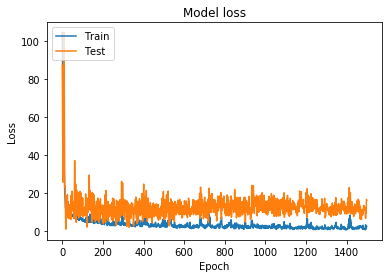

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Realizamos predicciones del test

In [12]:
model.predict(X_test)

array([[ 70008.81],
       [100638.24]], dtype=float32)

Comprobamos

In [13]:
y_test

,50
Iran,64586
China,80921


# Predicción

In [14]:
country_prediction_namelist = ['Mexico']

In [15]:
db = open('database_prediction.csv','w')

for value in range(dias_a_usar):
    print(value+1,file=db,end = ',')
print(dia_a_predecir,file=db)

for country in country_prediction_namelist:
    
    f = open('database_confirmed.csv')
    infected = []
    dia_inicio = 0
    for line in f:
        if(country == line.split(',')[1]):
            lat = float(line.split(',')[2])
            long = float(line.split(',')[3])
            country_data = []
            data = line.replace('\n','').split(',')[4:]
            for number in data:
                if(number != '0'):
                    infected.append(int(number))
                else:
                    dia_inicio += 1                    
    f.close()

    if(len(infected)<dias_a_usar):
        continue    
    print(country,end=',',file=db,sep=',')
    for value in infected[:dias_a_usar]:
        print(value,file=db,end = ',')
    if(len(infected)>=dia_a_predecir):
        print(infected[dia_a_predecir-1],file=db)
    else:
        print(-1,file=db)
db.close()          

In [16]:
data_prediction = pd.read_csv("database_prediction.csv",sep=',') 

In [17]:
data_prediction

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
Mexico,1,4,5,5,5,5,5,6,6,7,...,2785,3181,3441,3844,4219,4661,5014,5399,5847,-1


In [18]:
from sklearn.model_selection import train_test_split
X_prediction = pd.DataFrame()
for i in range(1,dias_a_usar+1):
    X_prediction[str(i)] = data_prediction[str(i)]
Y_prediction = pd.DataFrame()
Y_prediction[str(dia_a_predecir)] = data_prediction[str(dia_a_predecir)]
print(X_prediction.shape, Y_prediction.shape)

(1, 49) (1, 1)


In [19]:
model.predict(X_prediction)

array([[6502.965]], dtype=float32)